In [7]:
import pandas as pd
import numpy as np
import datetime as dt
from hyperopt import hp, tpe, fmin
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import lib

In [11]:
def preprocessing(path_stock): 
    df = pd.read_csv(path_stock)
    df = df[['STOCKID','TRADINGDATE','TRADINGTIME','OPENPRICE','LASTPRICE','HIGHPRICE','LOWPRICE','TOTALQTTY']]
    df.drop(['STOCKID'],axis=1,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.rename(columns={"TOTALVOL": "Volume", "TRADINGDATE":"Date", "TRADINGTIME":"Time", 'OPENPRICE':'Open','LASTPRICE':'Close','HIGHPRICE':'High','LOWPRICE':'Low','TOTALQTTY':'Volume'},inplace=True)
    df['DateTime'] = df['Date'] + ' ' + df['Time']
    df['DateTime'] = pd.to_datetime(df['DateTime'],format="%d-%b-%y %H:%M:%S")
    df.sort_values(by = ['DateTime'],inplace=True)
    df.drop_duplicates(subset=['DateTime'],keep='last',inplace=True)
    df.set_index('DateTime',inplace=True)
    df.drop(['Time'],axis=1,inplace=True)
    df = df[df.index.year > 2017]
    # df.reset_index(inplace=True)

    df_price = df[['Open','High','Low','Close']]
    df_vol = df['Volume']
    df_price = df_price.resample('5min').bfill()
    df_vol = df_vol.resample('5min').sum()
    df = pd.concat([df_price,df_vol],axis=1)
    df['Date'] = df.index.date

    df['QChange'] = df.Volume.diff()
    df['PChange'] = df.Close.diff()
    df = df[df.QChange != 0][df.Close != 0]
    df['Return'] = np.log((df.Close)/df.Close.shift(1)).dropna()*100
    df = df[['Open','High','Low','Close','Volume']]
    print(df.head())

    return df

def signal_generate(paras):
    df = paras['df']
    short_window = int(paras['short_window'])
    long_window = int(paras['long_window'])
    volume_factor = float(paras['volume_factor'])
    spread_factor = float(paras['spread_factor'])
    uptrend = 0
    signal_waiting = False
    no_selling_presure = False
    open_position = False
    previous_close = 0
    previous_volume=[0,0]
    df['Spread'] = df.High - df.Low      
    spreads = []
    vols = []
    
    # Initialize the `signals` DataFrame with the `signal` column
    signals = df[['Open','High','Low','Close','Volume','Spread']]
    signals['signal'] = 0.0

    # Create short and long EMA
    signals['short_ema'] = df.Close.ewm(span=short_window, adjust=False).mean()
    signals['long_ema'] = df.Close.ewm(span=long_window, adjust=False).mean()
    signals['average_vol'] = [np.mean(signals['Volume'][:i]) for i in range(len(signals))]
    signals['average_spread'] = [np.mean(signals['Spread'][:i]) for i in range(len(signals))]

    # Create signals
    for i in range(len(df)): 
        if i < short_window + 1: 
            continue
        else: 
            if open_position: 
                if signals['short_ema'][i] < signals['long_ema'][i]: 
                    signals.signal[i] = -1
                    open_position = False
            else: 

                if no_selling_presure and signals['short_ema'][i] > signals['long_ema'][i] and signals.Volume[i] > volume_factor*signals.average_vol[i]:
                    signals.signal[i] = 1
                    open_position = True
                elif signal_waiting: 
                    if signals.Volume[i] > signals.Volume[i-1] and signals.Volume[i] > signals.Volume[i-2] and signals.Spread[i]>0 and signals.Spread[i] < spread_factor*signals.average_spread[i]:
                        no_selling_presure = True
                        signal_waiting = False
                else:
                    if signals.Close[i] > signals.long_ema[i]: 
                        uptrend+=1 
                    if uptrend>2: 
                        signal_waiting = True    
    
    # Generate trading orders
    signals['position'] = signals['signal'].diff()
    
    return signals

def plot_signals(signals, paras):
    df = paras['df']
    short_window = int(paras['short_window'])
    long_window = int(paras['long_window'])
    
    fig = plt.figure(figsize = (11,4))
    ax1 = fig.add_subplot(111,  ylabel='Price')
    df['Close'].plot(ax=ax1, color='black', lw=1.)
    #Plot the short and long MA
    signals_plot = signals[['short_ema', 'long_ema']]
    signals_plot.columns = ['EMA({})'.format(short_window), 'EMA({})'.format(long_window)]
    signals_plot.plot(ax=ax1, lw=1.5)
    
    # Plot the buy signals
    ax1.plot(signals.loc[signals.position == 1.0].index, 
             signals.short_ema[signals.position == 1.0],
             'o', markersize=7, color='g', label = 'buy')      
    # Plot the sell signals
    ax1.plot(signals.loc[signals.position == -1.0].index, 
             signals.short_ema[signals.position == -1.0],
             'o', markersize=7, color='r', label = 'sell')
    #Show the plot
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.72))
    plt.show()

def compute_portfolio(signals, df):
    initial_capital= float(100000.0)
    position = pd.DataFrame(index=signals.index).fillna(0.0)
    
    # Buy a 100 shares
    position['df'] = 100*signals['signal']
    # Initialize the portfolio with value owned   
    portfolio = position.multiply(df['Close'], axis=0)
    # Store the difference in shares owned 
    pos_diff = position.diff()

    # Add `holdings` to portfolio
    portfolio['holdings'] = (position.multiply(df['Close'], axis=0)).sum(axis=1)
    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Close'], axis=0)).sum(axis=1).cumsum()   
    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()   

    #resample df and porfolio by day
    df_resample = pd.DataFrame(index=df.index).fillna(0.0)
    df_resample['close']  = df['Close']
    df_resample['day'] = df_resample.index.date
    df_resample = df_resample.groupby('day').last()

    portfolio_resample = pd.DataFrame(index=portfolio.index).fillna(0.0)
    portfolio_resample['total'] = portfolio['total'] 
    portfolio_resample['day'] = portfolio_resample.index.date
    portfolio_resample = portfolio_resample.groupby('day').last()
    portfolio_resample = pd.concat([portfolio_resample, df_resample], axis = 1)
    portfolio_resample['returns'] = portfolio_resample['total'].pct_change()

    
    return portfolio, portfolio_resample

def plot_portfolio(portfolio):
    # Create a figure
    fig = plt.figure(figsize = (11,4))
    ax1 = fig.add_subplot(111, ylabel='Portfolio value')
    # Plot the equity curve in dollars
    portfolio['total'].plot(ax=ax1, lw=2.)
    
    ax1.plot(portfolio.loc[signals.position == 1.0].index, 
             portfolio.total[signals.position == 1.0],
             'o', markersize=7, color='g', label = 'buy')
    ax1.plot(portfolio.loc[signals.position == -1.0].index, 
             portfolio.total[signals.position == -1.0],
             'o', markersize=7, color='r', label = 'sell')
    #Show the plot
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.72))
    plt.show()

    # Calculate Sharpe Ratio - Risk free rate element excluded for simplicity
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())
    
def backtesting(df, portfolio, portfolio_resample):  
    # Define a trailing 252 trading day window
    window = 252
    # Calculate the max drawdown in the past window days for each day 
    rolling_max = portfolio_resample['close'].rolling(window, min_periods=1).max()
    daily_drawdown = portfolio_resample['close']/rolling_max - 1.0
    # Calculate the minimum (negative) daily drawdown
    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
    
    # Plot the results
    daily_drawdown.plot()
    max_daily_drawdown.plot()
    plt.show()
    
    # annualized Sharpe ratio
    returns = portfolio_resample['returns']
    sharpe_ratio = annualised_sharpe(returns)
    print('Annualized Sharpe ratio:', sharpe_ratio)   
    print('volatility return', returns.std())
    print('mean return', returns.mean())
    print('initial porfolio value', portfolio['total'][0])
    print('final porfolio value', portfolio['total'][-1])
    
    # Get the number of days in data
    days = (portfolio_resample.index[-1] - portfolio_resample.index[0]).days
    # Calculate the CAGR 
    cagr = ((((portfolio_resample['close'][-1]) / portfolio_resample['close'][1])) ** (365.0/days)) - 1
    print('CAGR:', cagr)
    
def score(paras):
    signals = run_macrossover(paras)
    portfolio,portfolio_resample = compute_portfolio(signals)
    returns = portfolio_resample['returns']
    # annualized Sharpe ratio
    sharpe_ratio = annualised_sharpe(returns)
    return -sharpe_ratio

In [5]:
dict_stocks = {}
dict_stocks['FLC'] = preprocessing('FLC_980.csv')

                     Open  High   Low  Close    Volume
DateTime                                              
2018-01-02 09:15:00  6980  7000  6980   7000   9868400
2018-01-02 09:20:00  6980  7020  6980   7010  10846570
2018-01-02 09:25:00  6980  7020  6980   7020  14416900
2018-01-02 09:30:00  6980  7020  6980   7000  34120390
2018-01-02 09:35:00  6980  7020  6980   6990  20379070


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


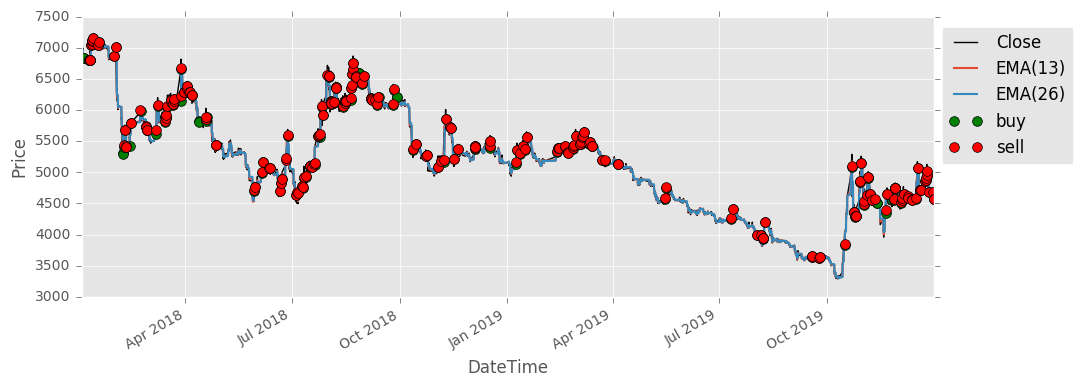

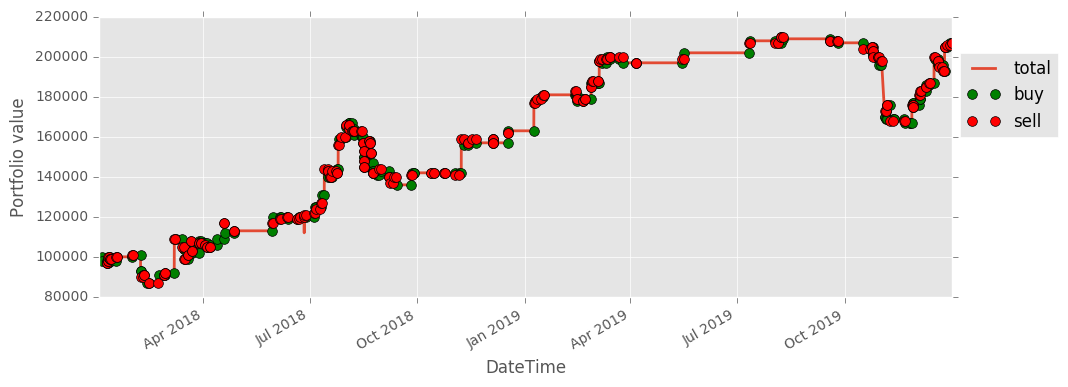

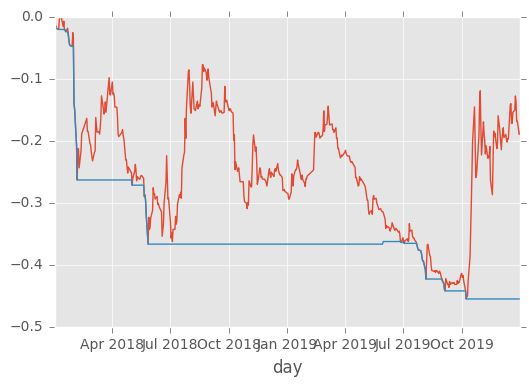

Annualized Sharpe ratio: 1.3723275131298323
volatility return 0.01905100806418054
mean return 0.0016469312144592944
initial porfolio value 100000.0
final porfolio value 207000.0
CAGR: -0.1779631527674702


In [12]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2020, 1, 1)
# end = dt.datetime.now()

# Initialize the parameters
df = dict_stocks['FLC'][start:end]

paras = {
    'df': df,
    'short_window': 13,
    'long_window': 26,
    'spread_factor' : 0.8,
    'volume_factor' : 1.3,
}

signals = signal_generate(paras)
plot_signals(signals, paras)

portfolio,portfolio_resample = compute_portfolio(signals, df)
plot_portfolio(portfolio)

backtesting(df, portfolio, portfolio_resample)

In [13]:
df_copy = df.copy()
df_copy['date'] = df_copy.index.date
df_copy.groupby('date').sum()

,Open,High,Low,Close,Volume,Spread
date,,,,,,
2018-01-02,362960,365020,362020,362710,3396711220,3000
2018-01-03,361400,363850,355870,357160,18557578410,7980
2018-01-04,353600,356650,353480,355690,8182430590,3170
2018-01-05,355680,356190,352600,354790,5055219240,3590
2018-01-08,353600,355160,352620,353800,5345305260,2540
2018-01-09,353600,356500,352620,355060,11059290630,3880
2018-01-10,368680,371230,365510,367420,16086531500,5720
2018-01-11,369200,372670,365580,369660,17047616640,7090
2018-01-12,374920,374920,371070,372670,11298687380,3850
